## Mounting the asset directory containing dataset

In [21]:
import os

local_assets_b = False

if local_assets_b:
  assets_dir = "/content/assets/P3/"

  if not os.path.isdir(assets_dir):
    assert os.path.isfile("assets.zip")
    os.system("unzip assets.zip")
else:
  from google.colab import drive
  drive.mount('/content/drive')
  assets_dir = '/content/drive/MyDrive/CV-3/Live Class Slides & Notebooks/assets/P3/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Similarity using Siamese Networks

Siamese Networks are a type of neural network architecture that can learn to compare and measure the similarity between two input samples. They are commonly used in tasks such as image similarity, face verification, and signature verification. Siamese Networks use shared weights to extract features from the input samples and compute a distance or similarity metric in the output layer.

The AT&T face dataset is a widely used benchmark dataset for face recognition tasks. It consists of grayscale images of faces from 40 different subjects, with 10 images per subject. The dataset provides a diverse range of facial variations, including different expressions, lighting conditions, and facial poses. The AT&T face dataset is often used for training and evaluating face recognition models and comparing their performance.

### Unzip the Dataset

In [22]:
import zipfile

# Path to the zip file you want to unzip
zip_file_path = assets_dir + "AT&T.zip"

# Target folder where you want to extract the contents
target_folder = "dataset"

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(target_folder)

### Imports

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision.models import vgg16
from torchvision.datasets import ImageFolder
import numpy as np
import random
import torchvision.transforms as transforms
import torch.nn.functional as F
from matplotlib import pyplot as plt

### Image Display and Plotting Functions

In [24]:
def imshow(img,text=None,should_save=False):
    """
    Display an image with optional text overlay.

    Parameters:
        img (torch.Tensor): The image tensor to display.
        text (str, optional): Text to overlay on the image. Default is None.
        should_save (bool, optional): Whether to save the image. Default is False.

    Returns:
        None
    """
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def show_plot(iteration,loss):
    """
    Plot the loss over iterations.

    Parameters:
        iteration (list): List of iteration numbers.
        loss (list): List of corresponding loss values.

    Returns:
        None
    """
    plt.plot(iteration, loss)
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title('Loss over Iterations')
    plt.show()

In [25]:
training_dir = "dataset/AT&T/train"
testing_dir = "dataset/AT&T/test/"

### Setting the Transformations

In [26]:
# Set device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform=transforms.Compose([transforms.Resize((100,100)),
                              transforms.ToTensor()
                            ])

### Dataset

Datasets are the collections of your training, validation, and test data. They consist of input samples and their corresponding target labels (for supervised learning). In PyTorch, datasets are typically created using custom classes inheriting from `torch.utils.data.Dataset`. You load your data into this class, allowing easy access during training.

### Siamese Dataset
We create a dataset from the images we have received where we create a dataset that contains an almost equal distribution of similar vs non-similar faces, thus helping train the Siamese Network to discern the differences between any 2 images thus determining similarity.

In [27]:
# Siamese Network Dataset
class SiameseNetworkDataset(Dataset):
    """
    Custom dataset for Siamese Network training.

    This dataset randomly samples pairs of images from the given input dataset, along with their corresponding labels
    indicating whether the images belong to the same class or not. It is used for training Siamese Networks which
    learn to compare and measure similarity between two input images.

    Parameters:
        dataset (Dataset): The original dataset containing images and their labels.

    """
    def __init__(self, dataset):
        """
        Initialize the Siamese Network dataset.

        Parameters:
            dataset (Dataset): The original dataset containing images and their labels.

        """
        self.dataset = dataset
        self.labels = torch.arange(len(dataset))

    def __getitem__(self, index):
        """
        Get a single sample from the Siamese Network dataset.

        Parameters:
            index (int): The index of the sample to retrieve.

        Returns:
            tuple: A tuple containing two images and a label. The first two elements are the two images (img1 and img2),
                   while the third element is a label (torch.Tensor) indicating whether the images belong to the same
                   class (1) or not (0).

        """
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            img1, label1 = self.dataset[index]
            # Randomly choose a different image with the same label
            while True:
                index2 = torch.randint(0, len(self.dataset), (1,))
                img2, label2 = self.dataset[index2]

                if label2 == label1:
                  break
            return img1, img2, torch.tensor(np.array([int(1)],dtype=np.float32))
        else:
            img1, label1 = self.dataset[index]
            # Randomly choose a different image with a different label
            while True:
                index2 = torch.randint(0, len(self.dataset), (1,))
                img2, label2 = self.dataset[index2]

                if label2 != label1:
                    break
            return img1, img2, torch.tensor(np.array([int(0)],dtype=np.float32))

    def __len__(self):
        """
        Get the total number of samples in the dataset.

        Returns:
            int: The total number of samples in the dataset.

        """
        return len(self.dataset)


In [28]:
train_dataset = ImageFolder(training_dir, transform=transform)
test_dataset = ImageFolder(testing_dir, transform=transform)

# Create Siamese datasets
train_siamese_dataset = SiameseNetworkDataset(train_dataset)
test_siamese_dataset = SiameseNetworkDataset(test_dataset)

### Dataloaders

Data Loaders wrap your dataset and provide functionalities for iterating through batches of data during training. They handle shuffling, batching, and parallel data loading, optimizing the data pipeline.

In [29]:
# Create data loaders
train_batch_size = 64
test_batch_size = 1

train_loader = DataLoader(train_siamese_dataset, batch_size=train_batch_size, shuffle=True, num_workers=8)
test_loader = DataLoader(test_siamese_dataset, batch_size=test_batch_size, shuffle=False)

In [30]:
print("Train Dataset for Siamese Network created.", len(train_siamese_dataset))
print("Test Dataset for Siamese Network created.", len(test_siamese_dataset))

Train Dataset for Siamese Network created. 370
Test Dataset for Siamese Network created. 30


## Siamese Network with VGG backbone

The below class defines a VGG backbone for the Siamese Network where we replace the last layer from the VGG model and then add a few dense layers to it.

In [31]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        Siamese Network with VGG-16 backbone for image similarity comparison.

        The network consists of a VGG-16 model with the last layer removed, followed by fully connected layers
        to extract features from input images. The extracted features are then used to compute image similarity.

        """
        super(SiameseNetwork, self).__init__()
        vgg = vgg16(pretrained=True)
        # Get the list of layers in the VGG-16 model.
        layers = list(vgg.children())
        # Remove the last layer from the list of layers.
        layers = layers[:-1]

        # Create a new model from the list of layers.
        self.fc0 = torch.nn.Sequential(*layers)
        self.fc1 = nn.Sequential(
          nn.Linear(25088, 2048),
          nn.ReLU(inplace=True),
          nn.Linear(2048, 512),
          nn.ReLU(inplace=True),
          nn.Linear(512, 9)
        )

    def forward_on_single_batch(self, x):
        """
        Perform forward pass for a single input image.

        Parameters:
            x (torch.Tensor): The input image tensor.

        Returns:
            torch.Tensor: The output feature tensor obtained after passing through the network layers.

        """
        x = self.fc0(x)
        x = x.view(x.size()[0], -1)
        x = self.fc1(x)
        return x

    def forward(self, input1, input2):
        """
        Perform forward pass for a pair of input images.

        Parameters:
            input1 (torch.Tensor): The first input image tensor.
            input2 (torch.Tensor): The second input image tensor.

        Returns:
            tuple: A tuple containing the output feature tensors obtained after passing each input image
                   through the network.

        """
        output1 = self.forward_on_single_batch(input1)
        output2 = self.forward_on_single_batch(input2)
        return output1, output2


In [32]:
# Create an instance of the Siamese Network with VGG16 backbone
model = SiameseNetwork().to(device)

### Learning Rate

The learning rate is a hyperparameter that controls how much the model's parameters should be updated during training.

In [33]:
lr = 0.001

### Optimizer

Optimizers are algorithms that adjust the model's parameters during training to minimize the loss function. Common optimizers include SGD (Stochastic Gradient Descent), Adam, and RMSprop.

In [34]:
optimizer = optim.Adam(model.parameters(), lr=lr)

### Loss Function

Loss functions measure the difference between the predicted output and the actual target values. Common loss functions include Cross-Entropy Loss for classification tasks and Mean Squared Error for regression tasks.

### Defining the Contrastive Loss Function

The Contrastive Loss function is commonly used in Siamese Networks for learning similarity metrics. It encourages similar samples to have small distances in the embedding space, while pushing dissimilar samples apart. The loss function computes the distance between pairs of samples and penalizes large distances for similar pairs and small distances for dissimilar pairs, guiding the network to learn meaningful representations that capture the similarity between inputs.

In [35]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive Loss function for Siamese Networks.

    This loss function computes the contrastive loss between the two output feature vectors of a Siamese Network,
    which are representations of two input images. The contrastive loss measures the similarity between the two images.
    It is used for training Siamese Networks, where the model learns to minimize the distance between similar images
    and maximize the distance between dissimilar images.

    Parameters:
        margin (float): The margin value used to define the threshold for dissimilarity. The default value is 2.0.

    """
    def __init__(self, margin=2.0):
        """
        Initialize the Contrastive Loss function.

        Parameters:
            margin (float): The margin value used to define the threshold for dissimilarity. The default value is 2.0.

        """
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Compute the Contrastive Loss.

        Parameters:
            output1 (torch.Tensor): The output feature vector of the first input image.
            output2 (torch.Tensor): The output feature vector of the second input image.
            label (torch.Tensor): The label indicating whether the two images are similar (1) or dissimilar (0).

        Returns:
            torch.Tensor: The computed Contrastive Loss.

        """
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [36]:
# Define the loss function
contrastive_loss = ContrastiveLoss()

In [37]:
def train_batch(epoch, model, optimizer, loss_history):
    print("epoch ", epoch)
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, batch in enumerate(train_loader):

        img1, img2, labels = batch
        img1 = img1.to(device) # Move the first image to the device
        img2 = img2.to(device) # Move the second image to the device
        labels = labels.to(device) # Move the labels to the device

        optimizer.zero_grad()  # Zero the gradients to prevent accumulation from previous iterations
        output1, output2 = model(img1, img2)  # Forward pass: get the output feature vectors for both images
        loss = contrastive_loss(output1, output2, labels) # Calculate the Contrastive Loss
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        optimizer.step()  # Update the model's parameters using the computed gradients

        train_loss += loss.item()
    print('Train Loss: %.3f'
                         % (train_loss/(batch_idx+1)))
    loss_history.append(train_loss)


In [38]:
def validate_batch(epoch, model, loss_history):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, batch in enumerate(test_loader):
            img1, img2, labels = batch
            img1 = img1.to(device) # Move the first image to the device
            img2 = img2.to(device) # Move the second image to the device
            labels = labels.to(device) # Move the labels to the device

            optimizer.zero_grad()  # Zero the gradients to prevent accumulation from previous iterations
            output1, output2 = model(img1, img2)  # Forward pass: get the output feature vectors for both images
            loss = contrastive_loss(output1, output2, labels) # Calculate the Contrastive Loss

            test_loss += loss.item()

    print('Val Loss: %.3f'
                 % (test_loss/(batch_idx+1)))
    loss_history.append(test_loss)

### Training the Model

In [39]:
from tqdm import tqdm
import time

# Initialize lists to track training progress
train_loss_history = [] # List to store the loss value during training
val_loss_history = [] # List to store the loss value during validation

# Training loop
num_epochs = 40

for epoch in tqdm(range(num_epochs), desc="Training epochs"):
    start_time = time.time()
    train_batch(epoch, model, optimizer, train_loss_history)
    validate_batch(epoch, model, val_loss_history)
    end_time = time.time()
    iteration_time = end_time - start_time
    tqdm.write(f"Epoch {epoch} took {iteration_time:.2f} seconds.")

Training epochs:   0%|          | 0/40 [00:00<?, ?it/s]

epoch  0
Train Loss: 116.666


Training epochs:   2%|▎         | 1/40 [00:07<04:48,  7.41s/it]

Val Loss: 2.644
Epoch 0 took 7.40 seconds.
epoch  1
Train Loss: 1.701


Training epochs:   5%|▌         | 2/40 [00:13<04:15,  6.72s/it]

Val Loss: 1.970
Epoch 1 took 6.22 seconds.
epoch  2
Train Loss: 1.534


Training epochs:   8%|▊         | 3/40 [00:20<04:09,  6.74s/it]

Val Loss: 1.697
Epoch 2 took 6.75 seconds.
epoch  3
Train Loss: 1.549


Training epochs:  10%|█         | 4/40 [00:26<03:58,  6.64s/it]

Val Loss: 2.122
Epoch 3 took 6.47 seconds.
epoch  4
Train Loss: 2.111


Training epochs:  12%|█▎        | 5/40 [00:33<03:50,  6.58s/it]

Val Loss: 2.916
Epoch 4 took 6.48 seconds.
epoch  5
Train Loss: 1.404


Training epochs:  15%|█▌        | 6/40 [00:40<03:46,  6.67s/it]

Val Loss: 2.931
Epoch 5 took 6.83 seconds.
epoch  6
Train Loss: 1.214


Training epochs:  18%|█▊        | 7/40 [00:46<03:35,  6.54s/it]

Val Loss: 1.958
Epoch 6 took 6.24 seconds.
epoch  7
Train Loss: 1.500


Training epochs:  20%|██        | 8/40 [00:54<03:41,  6.94s/it]

Val Loss: 1.361
Epoch 7 took 7.79 seconds.
epoch  8
Train Loss: 1.385


Training epochs:  22%|██▎       | 9/40 [00:59<03:20,  6.48s/it]

Val Loss: 2.286
Epoch 8 took 5.45 seconds.
epoch  9
Train Loss: 1.536


Training epochs:  25%|██▌       | 10/40 [01:09<03:40,  7.35s/it]

Val Loss: 2.282
Epoch 9 took 9.29 seconds.
epoch  10
Train Loss: 1.394


Training epochs:  28%|██▊       | 11/40 [01:14<03:19,  6.88s/it]

Val Loss: 1.885
Epoch 10 took 5.81 seconds.
epoch  11
Train Loss: 1.553


Training epochs:  30%|███       | 12/40 [01:23<03:26,  7.39s/it]

Val Loss: 1.821
Epoch 11 took 8.54 seconds.
epoch  12
Train Loss: 1.346


Training epochs:  32%|███▎      | 13/40 [01:29<03:10,  7.05s/it]

Val Loss: 2.310
Epoch 12 took 6.25 seconds.
epoch  13
Train Loss: 1.338


Training epochs:  35%|███▌      | 14/40 [01:37<03:06,  7.16s/it]

Val Loss: 1.612
Epoch 13 took 7.40 seconds.
epoch  14
Train Loss: 1.396


Training epochs:  38%|███▊      | 15/40 [01:43<02:50,  6.82s/it]

Val Loss: 1.622
Epoch 14 took 6.02 seconds.
epoch  15
Train Loss: 1.283


Training epochs:  40%|████      | 16/40 [01:50<02:45,  6.88s/it]

Val Loss: 2.136
Epoch 15 took 7.00 seconds.
epoch  16
Train Loss: 1.325


Training epochs:  42%|████▎     | 17/40 [01:56<02:33,  6.67s/it]

Val Loss: 2.243
Epoch 16 took 6.17 seconds.
epoch  17
Train Loss: 1.358


Training epochs:  45%|████▌     | 18/40 [02:02<02:25,  6.62s/it]

Val Loss: 1.283
Epoch 17 took 6.52 seconds.
epoch  18
Train Loss: 1.246


Training epochs:  48%|████▊     | 19/40 [02:08<02:15,  6.46s/it]

Val Loss: 1.815
Epoch 18 took 6.05 seconds.
epoch  19
Train Loss: 1.393


Training epochs:  50%|█████     | 20/40 [02:16<02:18,  6.93s/it]

Val Loss: 2.317
Epoch 19 took 8.01 seconds.
epoch  20
Train Loss: 1.354


Training epochs:  52%|█████▎    | 21/40 [02:22<02:06,  6.64s/it]

Val Loss: 1.842
Epoch 20 took 5.96 seconds.
epoch  21
Train Loss: 1.253


Training epochs:  55%|█████▌    | 22/40 [02:30<02:04,  6.93s/it]

Val Loss: 1.803
Epoch 21 took 7.58 seconds.
epoch  22
Train Loss: 1.314


Training epochs:  57%|█████▊    | 23/40 [02:36<01:52,  6.60s/it]

Val Loss: 2.110
Epoch 22 took 5.81 seconds.
epoch  23
Train Loss: 1.468


Training epochs:  60%|██████    | 24/40 [02:44<01:52,  7.04s/it]

Val Loss: 2.228
Epoch 23 took 8.05 seconds.
epoch  24
Train Loss: 1.375


Training epochs:  62%|██████▎   | 25/40 [02:50<01:42,  6.82s/it]

Val Loss: 1.299
Epoch 24 took 6.29 seconds.
epoch  25
Train Loss: 1.323


Training epochs:  65%|██████▌   | 26/40 [02:58<01:39,  7.10s/it]

Val Loss: 1.578
Epoch 25 took 7.76 seconds.
epoch  26
Train Loss: 1.236


Training epochs:  68%|██████▊   | 27/40 [03:04<01:28,  6.82s/it]

Val Loss: 2.080
Epoch 26 took 6.13 seconds.
epoch  27
Train Loss: 1.309


Training epochs:  70%|███████   | 28/40 [03:12<01:27,  7.25s/it]

Val Loss: 1.629
Epoch 27 took 8.25 seconds.
epoch  28
Train Loss: 1.253


Training epochs:  72%|███████▎  | 29/40 [03:18<01:14,  6.79s/it]

Val Loss: 1.590
Epoch 28 took 5.71 seconds.
epoch  29
Train Loss: 1.284


Training epochs:  75%|███████▌  | 30/40 [03:26<01:10,  7.06s/it]

Val Loss: 1.415
Epoch 29 took 7.68 seconds.
epoch  30
Train Loss: 1.315


Training epochs:  78%|███████▊  | 31/40 [03:32<01:01,  6.87s/it]

Val Loss: 2.662
Epoch 30 took 6.41 seconds.
epoch  31


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 250, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 411, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
OSError: [Errno 9] Bad file descriptor
Exception in thread QueueFeederThread:
Traceback (most recent call last):
  File "/usr/lib/python3.10/mul

Train Loss: 1.295


Training epochs:  80%|████████  | 32/40 [03:41<00:58,  7.30s/it]

Val Loss: 1.385
Epoch 31 took 8.29 seconds.
epoch  32
Train Loss: 1.287


Training epochs:  82%|████████▎ | 33/40 [03:46<00:48,  6.86s/it]

Val Loss: 1.569
Epoch 32 took 5.81 seconds.
epoch  33
Train Loss: 1.225


Training epochs:  85%|████████▌ | 34/40 [03:54<00:41,  6.99s/it]

Val Loss: 1.472
Epoch 33 took 7.29 seconds.
epoch  34
Train Loss: 1.248


Training epochs:  88%|████████▊ | 35/40 [04:00<00:34,  6.86s/it]

Val Loss: 2.017
Epoch 34 took 6.55 seconds.
epoch  35
Train Loss: 1.258


Training epochs:  90%|█████████ | 36/40 [04:08<00:28,  7.16s/it]

Val Loss: 1.462
Epoch 35 took 7.85 seconds.
epoch  36
Train Loss: 1.338


Training epochs:  92%|█████████▎| 37/40 [04:15<00:21,  7.11s/it]

Val Loss: 1.645
Epoch 36 took 6.96 seconds.
epoch  37
Train Loss: 1.299


Training epochs:  95%|█████████▌| 38/40 [04:23<00:14,  7.47s/it]

Val Loss: 1.584
Epoch 37 took 8.30 seconds.
epoch  38
Train Loss: 1.264


Training epochs:  98%|█████████▊| 39/40 [04:30<00:07,  7.16s/it]

Val Loss: 1.863
Epoch 38 took 6.44 seconds.
epoch  39
Train Loss: 1.279


Training epochs: 100%|██████████| 40/40 [04:38<00:00,  6.97s/it]

Val Loss: 1.463
Epoch 39 took 8.38 seconds.


### Plotting the loss

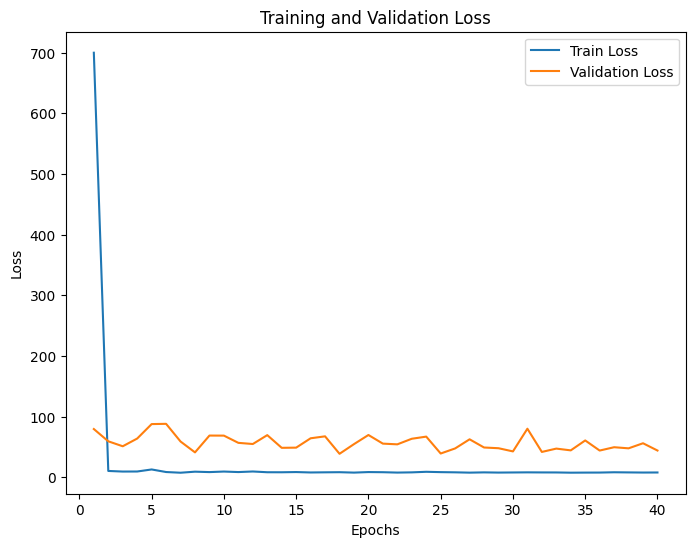

In [40]:
import matplotlib.pyplot as plt

# Plot the loss values using Matplotlib (optional)
epochs = list(range(1, len(train_loss_history) + 1))
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()


### Save the model

In [ ]:
state_dict = model.state_dict()
torch.save(state_dict, assets_dir + "siamese_model_state_dict.pt")

### Load the model

In [ ]:
file_path = assets_dir + 'siamese_model_state_dict.pt'
loaded_model = SiameseNetwork()
loaded_model.load_state_dict(torch.load(file_path))
loaded_model = loaded_model.to(device)

### Evaluating the Model

The Euclidean distance is a commonly used metric to quantify the similarity between two feature vectors in image analysis. It calculates the straight-line distance between the points in the feature space. Smaller distances indicate higher similarity, while larger distances indicate dissimilarity. The Euclidean distance metric is intuitive and straightforward to compute, making it widely used in various applications such as image retrieval and clustering.

In [ ]:
loaded_model = model

In [ ]:
import torchvision
from google.colab.patches import cv2_imshow

In [ ]:
# Evaluation
loaded_model.eval()  # Set the model to evaluation mode

with torch.no_grad():
    dataiter = iter(test_loader)
    x0,_,_ = next(dataiter)
    image1 = x0
    x0 = x0.to(device)

    for i in range(10):
        _,x1,label2 = next(dataiter)
        image2 = x1
        x1 = x1.to(device)

        # Concatenate two images side by side for visualization
        concatenated = torch.cat((image1,image2),0)

        # Forward pass through the Siamese Network to get the output feature vectors for both images
        output1,output2 = loaded_model(x0,x1)

        # Calculate the Euclidean distance between the output feature vectors
        euclidean_distance = F.pairwise_distance(output1, output2)

        # The 'cv2_imshow' function is used to display images in the Colab environment
        imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f}'.format(euclidean_distance.item()))

As we can see some more training might be required but the results seem to be good with similar faces having lesser dissimilarity vs different faces having more dissimilarity.